### Importing required libraries

In [32]:
#4d4b7105d754a06374d81259 category

#Download beautifulsoup4 library for webscraping, if not installed
!conda install beautifulsoup4

from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv 

# Downloading folium, if not installed
!conda install -c conda-forge folium=0.5.0 --yes
import folium # Map plotting library
import numpy as np
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         156 KB

The following packages will be UPDATED:

    certifi:         2019.11.28-py36_0     conda-forge --> 2019.11.28-py36_0
    openssl:         1.1.1d-h516909a_0     conda-forge --> 1.1.1d-h7b6447c_3

The following packages will be DOWNGRADED:

    ca-certificates: 2019.11.28-hecc5488_0 conda-forge --> 2019.11.27-0     


certifi-2019.11.28   | 156 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following pa

### Load CSV file from assets to dataframe.

In [38]:
# The code was removed by Watson Studio for sharing.

,Postcode,Neighbourhood
0,100,Helsinki Keskusta - Etu-Töölö
1,120,Punavuori
2,130,Kaartinkaupunki
3,140,Kaivopuisto - Ullanlinna
4,150,Eira - Hernesaari


### Getting the `shape` of the dataframe

In [39]:
df.shape

(84, 2)

### Getting the list of postal codes

In [40]:
area_names = df['Neighbourhood'].values

### OpenCage GeoCoder API and Foursquare API credentials

In [41]:
# Geocoder credential
API_KEY = 'b838d2e3f21f4c4f94c85d44d3cecc2c'
# Foursquare credentials
CLIENT_ID = 'KHBGHPJ5VNNCZME040UUNYNCYJCKU0GJ0NTHFVQ41OFKUHYL'
CLIENT_SECRET = 'KHHLC402HFX0EVWDKPBI4Q1F0JQ3OPG5TJOMYHWYTKQTWGFJ'
VERSION = '20200115'

### Using the OpenCage GeoCoder API to get coordinates

In [42]:
import json

latitudes = [] # Initializing the latitude array
longitudes = [] # Initializing the longitude array

for area in area_names :  
    place_name = area + " Helsinki" # Formats the place name
    url = 'https://api.opencagedata.com/geocode/v1/json?q={}&key={}'.format(place_name, API_KEY) # Gets the proper url to make the API call
    obj = json.loads(requests.get(url).text) # Loads the JSON file in the form of a python dictionary
    
    results = obj['results'] # Extracts the results information out of the JSON file
    lat = results[0]['geometry']['lat'] # Extracts the latitude value
    lng = results[0]['geometry']['lng'] # Extracts the longitude value
    
    latitudes.append(lat) # Appending to the list of latitudes
    longitudes.append(lng) # Appending to the list of longitudes

### Adding the latitude and longitude values to the dataframe

In [43]:
df['Latitude'] = latitudes
df['Longitude'] = longitudes

In [44]:
df.head()

,Postcode,Neighbourhood,Latitude,Longitude
0,100,Helsinki Keskusta - Etu-Töölö,60.172070,24.931243
1,120,Punavuori,60.161237,24.936505
2,130,Kaartinkaupunki,60.165214,24.947222
3,140,Kaivopuisto - Ullanlinna,60.159529,24.954969
4,150,Eira - Hernesaari,60.148740,25.098480


### Creating folium map of helsinki with neighbourhoods

In [45]:
# Helsinki latitude and longitude using Google search
hel_lat = 60.192059
hel_lng = 24.945831

# Creates map of Helsinki using latitude and longitude values
map_helsinki = folium.Map(location=[hel_lat, hel_lng], zoom_start=12)

# Add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_helsinki)  
    
map_helsinki

### Custom function for name and category

In [46]:
# Gets the name of the category

def get_category_type(row):
    try:
        categories_list = row['Category']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Using the FourSquare API on all neighbourhoods

In [47]:
explore_df_list = []

for i, nbd_name in enumerate(df['Neighbourhood']):  
    
    try :         
        ### Getting the data of neighbourhood
        nbd_name = df.loc[i, 'Neighbourhood']
        nbd_lat = df.loc[i, 'Latitude']
        nbd_lng = df.loc[i, 'Longitude']

        radius = 200 # Setting the radius as 200 metres
        LIMIT = 100 # Getting the top 100 venues

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flattens JSON

        # Filtering the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Renaming the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Gets the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)

        # Gets the data required
        for i, name in enumerate(nearby['Name']):
            explore_df_list.append([nbd_name, nbd_lat, nbd_lng] + nearby.loc[i, :].values.tolist())
    
    except Exception as e:
        pass

### Creating a dataframe for performing clustering operations

In [48]:
explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Helsinki Keskusta - Etu-Töölö,60.17207,24.931243,Arkadia Oy International Bookshop,Bookstore,60.173369,24.929330
1,Helsinki Keskusta - Etu-Töölö,60.17207,24.931243,Taidehalli,Art Gallery,60.172127,24.931014
2,Helsinki Keskusta - Etu-Töölö,60.17207,24.931243,Ateljé Finne,Scandinavian Restaurant,60.171198,24.928515
3,Helsinki Keskusta - Etu-Töölö,60.17207,24.931243,Luonnontieteellinen museo,Science Museum,60.171350,24.931549
4,Helsinki Keskusta - Etu-Töölö,60.17207,24.931243,Terrace,Beer Garden,60.173639,24.932516


### Total number of unique categories

In [49]:
len(explore_df['Venue Category'].unique())

155

### Performing one-hot encoding to analyze neighbourhoods

In [50]:
# One hot encoding
helsinki_onehot = pd.get_dummies(explore_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
helsinki_onehot['Neighbourhood'] = explore_df['Neighbourhood'] 

# Move neighborhood column to the first column
fixed_columns = [helsinki_onehot.columns[-1]] + list(helsinki_onehot.columns[:-1])
helsinki_onehot = helsinki_onehot[fixed_columns]

helsinki_onehot.head()

,Neighbourhood,Accessories Store,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Helsinki Keskusta - Etu-Töölö,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating new dataframe to sum all most commonly used venue types and plotting it

In [51]:
import matplotlib.pyplot as plt
helsinki_onehot_sum = helsinki_onehot.drop.sum()('Neighbourhood', axis=1).sum(axis=0)
helsinki_onehot_sum

AttributeError: 'function' object has no attribute 'sum'

In [22]:
helsinki_onehot_sum.sort_values(ascending=False)[:20].plot(kind='barh') # Top 20 most used venues

NameError: name 'helsinki_onehot_sum' is not defined

### Aggregating venues by neighbourhoods

In [52]:
helsinki_grouped = helsinki_onehot.groupby('Neighbourhood').mean().reset_index()
helsinki_grouped.head()

,Neighbourhood,Accessories Store,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Aurinkolahti,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Etelä-Haaga,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Etelä-Vuosaari,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Etu-Vallila - Alppila,0.0,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Helsinki Keskusta - Etu-Töölö,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating a function to return the most common venues

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating a new dataframe to get the top 10 venues

In [54]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = helsinki_grouped['Neighbourhood']

for ind in np.arange(helsinki_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(helsinki_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aurinkolahti,Beach,Restaurant,Ice Cream Shop,Yoga Studio,Food Court,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant
1,Etelä-Haaga,Bus Stop,Convenience Store,Cafeteria,Falafel Restaurant,French Restaurant,Grocery Store,Gift Shop,Gastropub,Garden Center,Garden
2,Etelä-Vuosaari,Recreation Center,Pizza Place,Taxi Stand,Gym / Fitness Center,Cafeteria,Café,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop
3,Etu-Vallila - Alppila,Theme Park Ride / Attraction,Gym,Event Space,Chinese Restaurant,Pizza Place,Bar,Park,History Museum,Forest,Garden Center
4,Helsinki Keskusta - Etu-Töölö,Scandinavian Restaurant,Bookstore,Art Gallery,Jazz Club,Beer Garden,Science Museum,Gastropub,Garden Center,Garden,Furniture / Home Store
5,Herttoniemi,Bus Stop,Convenience Store,Liquor Store,Grocery Store,Supermarket,Café,Gastropub,Bus Station,Himalayan Restaurant,Chinese Restaurant
6,Itä-Pakila,Bus Stop,Ice Cream Shop,Bus Station,Construction & Landscaping,Park,Flea Market,Flower Shop,Filipino Restaurant,Food Court,Food Truck
7,Itä-Pasila,Comedy Club,Liquor Store,Restaurant,Thai Restaurant,Sandwich Place,Supermarket,Toy / Game Store,Garden,Furniture / Home Store,French Restaurant
8,Jakomäki - Alppikylä,Supermarket,Bus Stop,Plaza,Shopping Mall,Grocery Store,Pharmacy,Karaoke Bar,Convenience Store,Garden,Furniture / Home Store
9,Jollas,Playground,Yoga Studio,Food Court,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Truck


# Few histograms to study top 3 common venue types in all neighbourhoods

### 1st Most Common Venues

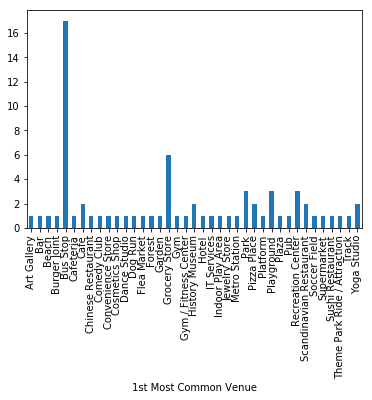

In [55]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue')['Neighbourhood'].nunique().plot(kind='bar')
plt.show()

### 2nd Most Common Venues

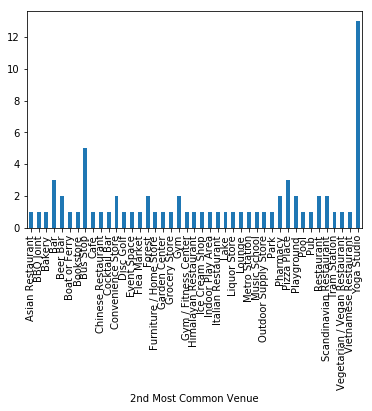

In [56]:
neighbourhoods_venues_sorted.groupby('2nd Most Common Venue')['Neighbourhood'].nunique().plot(kind='bar')
plt.show()

### 3rd Most Common Venues

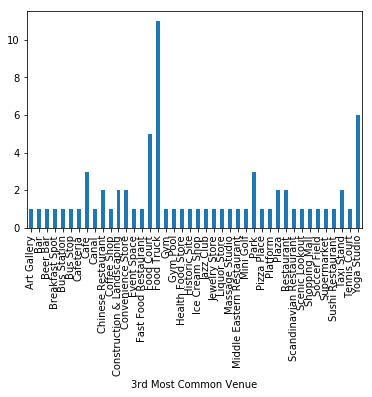

In [57]:
neighbourhoods_venues_sorted.groupby('3rd Most Common Venue')['Neighbourhood'].nunique().plot(kind='bar')
plt.show()

### Using K-Means clustering

In [58]:
# Set number of clusters
kclusters = 7
helsinki_grouped_clustering = helsinki_grouped.drop('Neighbourhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(helsinki_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### Creating a grand dataframe containing the necessary data

In [59]:
helsinki_merged = df
helsinki_merged = helsinki_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
helsinki_merged.dropna(inplace = True)
helsinki_merged['Cluster Labels'] = helsinki_merged['Cluster Labels'].astype(int)
helsinki_merged.head()

,Postcode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100,Helsinki Keskusta - Etu-Töölö,60.172070,24.931243,1,Scandinavian Restaurant,Bookstore,Art Gallery,Jazz Club,Beer Garden,Science Museum,Gastropub,Garden Center,Garden,Furniture / Home Store
1,120,Punavuori,60.161237,24.936505,1,Yoga Studio,Beer Bar,Scandinavian Restaurant,Park,Coffee Shop,Sushi Restaurant,Grocery Store,IT Services,Indie Theater,Furniture / Home Store
2,130,Kaartinkaupunki,60.165214,24.947222,1,Scandinavian Restaurant,Cocktail Bar,Restaurant,Pizza Place,Hotel,Music Venue,Filipino Restaurant,Dumpling Restaurant,Steakhouse,French Restaurant
3,140,Kaivopuisto - Ullanlinna,60.159529,24.954969,1,Grocery Store,Tram Station,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
5,160,Katajanokka,60.166975,24.968151,1,Hotel,Scandinavian Restaurant,Park,Construction & Landscaping,Skating Rink,Restaurant,Bar,Gym / Fitness Center,Tram Station,Hostel


### Visualizing the clusters

In [60]:
# Create map
map_clusters = folium.Map(location=[hel_lat, hel_lng], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(helsinki_merged['Latitude'], helsinki_merged['Longitude'], helsinki_merged['Neighbourhood'], helsinki_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

### Cluster 0

In [61]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 0, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,Roihupellon teollisuusalue,Indoor Play Area,Yoga Studio,Food Court,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Truck


### Cluster 1

In [62]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 1, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Helsinki Keskusta - Etu-Töölö,Scandinavian Restaurant,Bookstore,Art Gallery,Jazz Club,Beer Garden,Science Museum,Gastropub,Garden Center,Garden,Furniture / Home Store
1,Punavuori,Yoga Studio,Beer Bar,Scandinavian Restaurant,Park,Coffee Shop,Sushi Restaurant,Grocery Store,IT Services,Indie Theater,Furniture / Home Store
2,Kaartinkaupunki,Scandinavian Restaurant,Cocktail Bar,Restaurant,Pizza Place,Hotel,Music Venue,Filipino Restaurant,Dumpling Restaurant,Steakhouse,French Restaurant
3,Kaivopuisto - Ullanlinna,Grocery Store,Tram Station,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
5,Katajanokka,Hotel,Scandinavian Restaurant,Park,Construction & Landscaping,Skating Rink,Restaurant,Bar,Gym / Fitness Center,Tram Station,Hostel
6,Kruununhaka,Grocery Store,Bar,Sushi Restaurant,Organic Grocery,Chinese Restaurant,Café,Theater,Korean Restaurant,Hostel,Pizza Place
7,Kamppi - Ruoholahti,Metro Station,Beer Bar,Canal,Middle Eastern Restaurant,Grocery Store,Food Truck,Himalayan Restaurant,Spa,Park,Sandwich Place
8,Suomenlinna,History Museum,Boat or Ferry,Café,Island,Bar,Tourist Information Center,Gift Shop,Gastropub,Garden Center,Garden
10,Vattuniemi,IT Services,Asian Restaurant,Bar,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant
11,Jätkäsaari,Bar,Vietnamese Restaurant,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant


### Cluster 2

In [63]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 2, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Lauttasaari,Bus Stop,Playground,Chinese Restaurant,Restaurant,Metro Station,Bar,Thai Restaurant,Forest,Garden Center,Garden
21,Etelä-Haaga,Bus Stop,Convenience Store,Cafeteria,Falafel Restaurant,French Restaurant,Grocery Store,Gift Shop,Gastropub,Garden Center,Garden
24,Munkkivuori-Niemenmäki,Bus Stop,Pizza Place,Mini Golf,Cafeteria,Parking,Café,Flea Market,Flower Shop,Filipino Restaurant,Food Court
25,Pajamäki,Pub,Pharmacy,Historic Site,Bus Stop,Food Truck,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant
32,Maununneva,Grocery Store,Bus Stop,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
40,Toukola-Vanhakaupunki,History Museum,Bus Stop,Park,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
44,Koskela-Helsinki,Bus Stop,BBQ Joint,Scenic Lookout,Grocery Store,Fast Food Restaurant,Falafel Restaurant,Filipino Restaurant,Flea Market,Event Space,Flower Shop
46,Metsälä-Etelä-Oulunkylä,Bus Stop,Gym,Platform,Pizza Place,Pharmacy,Fast Food Restaurant,Outdoor Sculpture,Flower Shop,Supermarket,Taxi Stand
48,Oulunkylä-Patola,Bus Stop,Park,Construction & Landscaping,Cafeteria,French Restaurant,Grocery Store,Gift Shop,Gastropub,Garden Center,Garden
50,Länsi-Pakila,Bus Stop,Furniture / Home Store,Soccer Field,Flower Shop,Forest,Gift Shop,Gastropub,Garden Center,Garden,French Restaurant


### Cluster 3

In [64]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 3, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Ruskeasuo,Gym,Forest,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Food Court
30,Malminkartano,Forest,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Food Court
75,Puotila,Garden,Forest,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden Center,Furniture / Home Store,French Restaurant,Food Court


### Cluster 4

In [65]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 4, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Kaitalahti,Bus Stop,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
51,Paloheinä,Bus Stop,Pool,Yoga Studio,Forest,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant
55,Pihlajamäki,Bus Stop,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
63,Viikki,Bus Stop,Lake,Yoga Studio,Forest,Grocery Store,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store
64,Länsi-Herttoniemi,Bus Stop,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest
79,Vartioharju,Bus Stop,Garden Center,Yoga Studio,Food Truck,Gift Shop,Gastropub,Garden,Furniture / Home Store,French Restaurant,Forest


### Cluster 5

In [66]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 5, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Reimarla,Park,Yoga Studio,Food Truck,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Court
67,Tammisalo,Playground,Grocery Store,Park,Food Court,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Truck
69,Jollas,Playground,Yoga Studio,Food Court,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Truck
70,Santahamina,Playground,Yoga Studio,Food Court,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Truck
78,Kontula - Vesala,Art Gallery,Playground,Pizza Place,Park,Yoga Studio,Food Court,Garden Center,Garden,Furniture / Home Store,French Restaurant


### Cluster 6

In [67]:
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 6, helsinki_merged.columns[[1] + list(range(5, helsinki_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Siltamäki,Soccer Field,Yoga Studio,Food Truck,Gastropub,Garden Center,Garden,Furniture / Home Store,French Restaurant,Forest,Food Court
